# MACHINE LEARNING IN PRODUCTION MADRID - MLFLOW APPROACH

In previous lessons we've seen the feature engineering process of our dataset and we tried out the HDBSCAN algorithm for clustering. In this notebook we'll just focus on the training part (clusterization) using a KMeans algorithm from Scikit-Learn for the sake of simplicity.

We'll compare the traditional Machine Learning training approach with the new MLFlow paradigma. In order to focus just on training we'll load the embedding that comes from the UMAP projection (checkpoint in previous lesson).

## Traditional approach

### ETL

In [1]:
import pandas as pd  

pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 3.10.0-1062.4.3.el7.x86_64
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.1
numpy            : 1.16.2
pytz             : 2018.9
dateutil         : 2.8.0
pip              : 20.0.2
setuptools       : 41.6.0
Cython           : 0.29.6
pytest           : 4.3.1
hypothesis       : None
sphinx           : 1.8.5
blosc            : None
feather          : None
xlsxwriter       : 1.1.5
lxml.etree       : 4.3.2
html5lib         : 1.0.1
pymysql          : None
psycopg2         : 2.8.3 (dt dec pq3 ext)
jinja2           : 2.10.3
IPython          : 7.4.0
pandas_datareader: None
bs4              : 4.7.1
bottleneck       : 1.2.1
fastparquet      : 0.2.1
gcsfs            : None
lxml.etree       : 4.3.2
mat

In [2]:
# modified below code so that data can be read from  s3

path = "embedding.parquet"  # about 60MB in .parquet file, but 3.5Gb in memory, be careful!
bucket = "dsla"
folder = "ml-in-production/data/output/processed"
bucket_uri = f's3://{bucket}/{folder}/{path}'
print(bucket_uri)

df = pd.read_parquet(bucket_uri)

df.head()

s3://dsla/ml-in-production/data/output/processed/embedding.parquet


,x,y
0,-2.540982,-2.726460
1,-1.608069,12.417865
2,-3.363984,-5.863577
3,14.502577,2.635897
4,-2.051581,-10.573081


### Clustering

In [3]:
import numpy as np
from sklearn.cluster import KMeans
    
# parameters for KMeans
n_clusters = 12
algorithm = 'elkan'
tol=1e-3

kmeans_m = KMeans(n_clusters=n_clusters,
                  algorithm=algorithm,
                  tol=1e-3,
                  random_state=42,
                  precompute_distances=True, 
                  n_jobs=-1)

clustering = kmeans_m.fit_predict(df)

print(f'Cluster Ids: {np.sort(np.unique(clustering))}')

Cluster Ids: [ 0  1  2  3  4  5  6  7  8  9 10 11]


### Metrics

In order to evaluate how good or bad is our model we'll use the silhouette score and the inertia.

In [4]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(df, clustering)
print(f'Silhouette Score: {silhouette}')

inertia = kmeans_m.inertia_
print(f'Inertia: {inertia}')

Silhouette Score: 0.5289595723152161
Inertia: 34998.90367505566


It is also useful to save the clustering plot to check how it is related with the clustering metrics

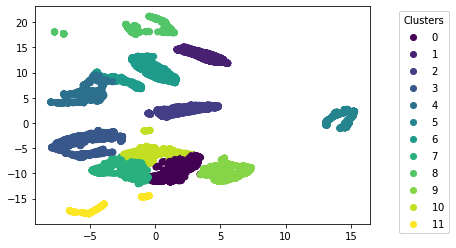

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots()

scatter = ax.scatter(x=df['x'], 
                     y=df['y'], 
                     c=clustering)
legend = ax.legend(*scatter.legend_elements(num=n_clusters), 
                   title='Clusters', 
                   loc='upper right', 
                   bbox_to_anchor=(1.25,1.0))
ax.add_artist(legend);

output_folder = '../output/figures'

!if [ ! -d $output_folder ]; then mkdir -p $output_folder; fi

figure_path = f'{output_folder}/{n_clusters}_{algorithm}_{tol}.png'
plt.show()
plt.savefig(figure_path)
plt.close()


In [6]:
# Upload to S3 instead of saving to local

import io
import boto3 # Amazon's aws library for python 3

# create a connection to s3
s3 = boto3.resource('s3')

bucket = "dsla"
figure_path = f'{output_folder}/{n_clusters}_{algorithm}_{tol}.png'

# upload image to aws s3
# warning, the ACL here is set to private (not public-read)

print(figure_path)

img_data = open(figure_path, "rb")
print(img_data)

s3.Bucket(bucket).put_object(Key=f'{n_clusters}_{algorithm}_{tol}.png', Body=img_data, 
                       ContentType="image/png" , ACL="private")

# Generate the URL to get 'key-name' from 'bucket-name'
url = "http://" + bucket + ".s3.amazonaws.com/" +  f'{output_folder}/{n_clusters}_{algorithm}_{tol}.png'
# this url should open the uploaded image as an image in a browser window  

../output/figures/12_elkan_0.001.png
<_io.BufferedReader name='../output/figures/12_elkan_0.001.png'>


## MLFlow approach

Now is the time of seeing how this model would be trained using the MLFlow API and the benefits of doing it this way over the traditional approach

### ETL

In order to clean the code a little bit most of the imports have been defined here

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

In [8]:
# modified below code so that data can be read from  s3

path = "embedding.parquet"  # about 60MB in .parquet file, but 3.5Gb in memory, be careful!
bucket = "dsla"
folder = "ml-in-production/data/output/processed"
bucket_uri = f's3://{bucket}/{folder}/{path}'
print(bucket_uri)

df = pd.read_parquet(bucket_uri)

#df = pd.read_parquet('../output/processed/embedding.parquet')

df.head()

s3://dsla/ml-in-production/data/output/processed/embedding.parquet


,x,y
0,-2.540982,-2.726460
1,-1.608069,12.417865
2,-3.363984,-5.863577
3,14.502577,2.635897
4,-2.051581,-10.573081


### MLFlow Setup

The first step is to create an MLFlow experiment, so that all runs of our training process could be well organized. It is also needed specify which is the URL of our Tracking Server.

In [9]:
import mlflow

mlflow.set_tracking_uri('http://usaeilidssbxd01.syngentaaws.org:8888')
#mlflow.set_tracking_uri('http://usaeilidssbxp01.syngentaaws.org:8888')

mlflow.set_experiment('ml-in-production-experiment')

### MLFlow Train

Then, the following step would be creating a run for the experiment so that all the training process could be monitored and logged. This can be done just with the mlflow.start_run() sentence. The rest of API calls are explained with comments over the next cell.

Silhouette Score: 0.5289595723152161
Inertia: 34998.90367505566


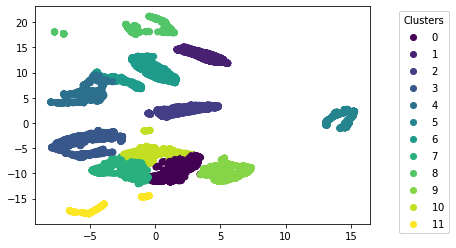

In [10]:
import mlflow.sklearn

# starts run and closes it after all code has been executed
with mlflow.start_run():
    
    # parameters for KMeans
    n_clusters = 12
    algorithm = 'elkan'
    tol=1e-3

    # training
    kmeans_m = KMeans(n_clusters=n_clusters,
                      algorithm=algorithm,
                      tol=1e-3,
                      random_state=42,
                      precompute_distances=True, 
                      n_jobs=-1)
    clustering = kmeans_m.fit_predict(df)

    # metrics
    silhouette = silhouette_score(df, clustering)
    print(f'Silhouette Score: {silhouette}')

    inertia = kmeans_m.inertia_
    print(f'Inertia: {inertia}')
    
    fig, ax = plt.subplots()

    scatter = ax.scatter(x=df['x'], 
                         y=df['y'], 
                         c=clustering)
    legend = ax.legend(*scatter.legend_elements(num=n_clusters), 
                       title='Clusters', 
                       loc='upper right', 
                       bbox_to_anchor=(1.25,1.0))
    ax.add_artist(legend);
    
    output_folder = '../output/figures'

    !if [ ! -d $output_folder ]; then mkdir -p $output_folder; fi

    figure_path = f'{output_folder}/{n_clusters}_{algorithm}_{tol}.png'
    plt.show()
    plt.savefig(figure_path)
    plt.close()
    
    # here starts the MLFlow monitoring
    
    # first the model hyperparameters are logged to the tracking server
    mlflow.log_param('n_clusters', n_clusters)
    mlflow.log_param('algorithm', algorithm)
    mlflow.log_param('tol', tol)
    
    # then the metrics resulting from the training process
    mlflow.log_metric('silhouette', silhouette)
    mlflow.log_metric('inertia', inertia)
        
    mlflow.log_artifact(figure_path,'figures')
    
    # finally the model is logged
    mlflow.sklearn.log_model(kmeans_m,'model')

In [11]:
# Upload to S3 instead of saving to local

import io
import boto3 # Amazon's aws library for python 3

# create a connection to s3
s3 = boto3.resource('s3')

# bucket is already defined above 
print(bucket)

# upload image to aws s3
# warning, the ACL here is set to private (not public-read)

print(figure_path)

img_data = open(figure_path, "rb")
print(img_data)

s3.Bucket(bucket).put_object(Key= f'{n_clusters}_{algorithm}_{tol}.png', Body=img_data, 
                       ContentType="image/png" , ACL="private")

# Generate the URL to get 'key-name' from 'bucket-name'
url = "http://" + bucket + ".s3.amazonaws.com/" +  f'{n_clusters}_{algorithm}_{tol}.png'
# this url should open the uploaded image as an image in a browser window  


dsla
../output/figures/12_elkan_0.001.png
<_io.BufferedReader name='../output/figures/12_elkan_0.001.png'>


In [12]:
    # here starts the MLFlow monitoring
    
    # first the model hyperparameters are logged to the tracking server
    mlflow.log_param('n_clusters', n_clusters)
    mlflow.log_param('algorithm', algorithm)
    mlflow.log_param('tol', tol)
    
    # then the metrics resulting from the training process
    mlflow.log_metric('silhouette', silhouette)
    mlflow.log_metric('inertia', inertia)
        
    mlflow.log_artifact(figure_path,'figures')
    
    # finally the model is logged
    mlflow.sklearn.log_model(kmeans_m,'model')

### MLFlow Train Several Times

The training process used to be performed manually in the traditional way, changing cells in the Jupyter Notebook and waiting for the results, trying to get the configuration that suits the best to the model performance. With MLFlow you can just run again and again with the confidence of being logging everything and recover that configuration that once worked amazing.

So in order to organize the code a little bit, a train function has been defined.

In [13]:
def train(n_clusters, algorithm, tol):
    
    # training
    kmeans_m = KMeans(n_clusters=n_clusters,
                      algorithm=algorithm,
                      tol=tol,
                      random_state=42,
                      precompute_distances=True, 
                      n_jobs=-1)
    clustering = kmeans_m.fit_predict(df)

    # metrics
    silhouette = silhouette_score(df, clustering)
    print(f'Silhouette Score: {silhouette}')

    inertia = kmeans_m.inertia_
    print(f'Inertia: {inertia}')
    
    fig, ax = plt.subplots()

    scatter = ax.scatter(x=df['x'], 
                         y=df['y'], 
                         c=clustering)
    legend = ax.legend(*scatter.legend_elements(num=n_clusters - 1), 
                       title='Clusters', 
                       loc='upper right', 
                       bbox_to_anchor=(1.25,1.0))
    ax.add_artist(legend);
    
    output_folder = '../output/figures'

    !if [ ! -d $output_folder ]; then mkdir -p $output_folder; fi

    figure_path = f'{output_folder}/{n_clusters}_{algorithm}_{tol}.png'
    plt.show()
    plt.savefig(figure_path)
    plt.close()

    # here starts the MLFlow monitoring
    
    # first the model hyperparameters are logged to the tracking server
    mlflow.log_param('n_clusters', n_clusters)
    mlflow.log_param('algorithm', algorithm)
    mlflow.log_param('tol', tol)
    
    # then the metrics resulting from the training process
    mlflow.log_metric('silhouette', silhouette)
    mlflow.log_metric('inertia', inertia)

    # the figure with the clustering plot can also be logged
    mlflow.log_artifact(figure_path, 'figures')
    
    # finally the model is logged
    mlflow.sklearn.log_model(kmeans_m, 'model')

In [14]:
mlflow.end_run()

Then we can try out the training process with different parameters in a loop.


Training KMeans for 6 clusters, full algorithm and tol 0.1...
                
Silhouette Score: 0.47094619274139404
Inertia: 119844.49786940168


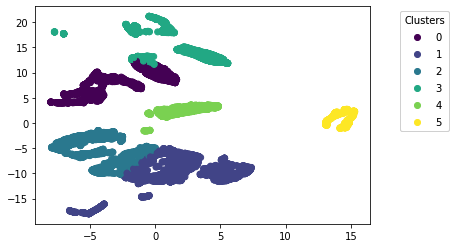


Training KMeans for 6 clusters, full algorithm and tol 0.001...
                
Silhouette Score: 0.474467396736145
Inertia: 118936.67586142692


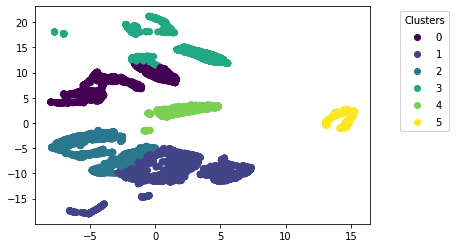


Training KMeans for 6 clusters, elkan algorithm and tol 0.1...
                
Silhouette Score: 0.47094619274139404
Inertia: 119844.49786940165


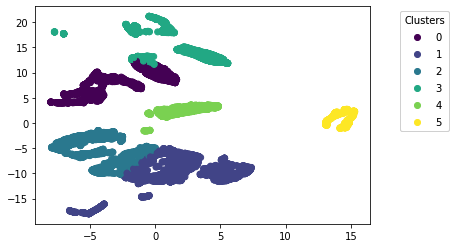


Training KMeans for 6 clusters, elkan algorithm and tol 0.001...
                
Silhouette Score: 0.4748874008655548
Inertia: 118934.7626102172


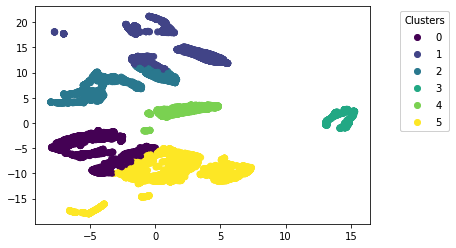


Training KMeans for 12 clusters, full algorithm and tol 0.1...
                
Silhouette Score: 0.5234900712966919
Inertia: 36675.5465175788


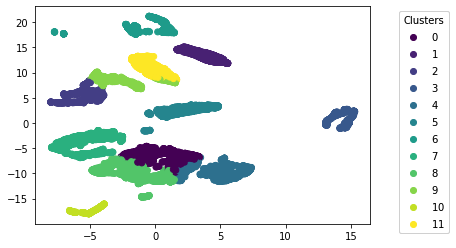


Training KMeans for 12 clusters, full algorithm and tol 0.001...
                
Silhouette Score: 0.5280594229698181
Inertia: 35048.63872120991


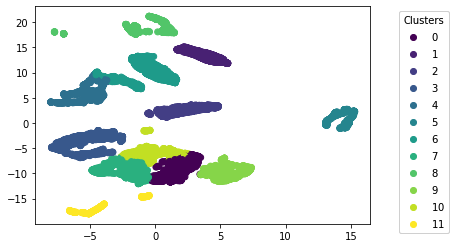


Training KMeans for 12 clusters, elkan algorithm and tol 0.1...
                
Silhouette Score: 0.5257962942123413
Inertia: 35756.716200249604


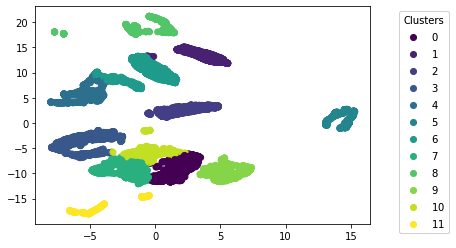


Training KMeans for 12 clusters, elkan algorithm and tol 0.001...
                
Silhouette Score: 0.5289595723152161
Inertia: 34998.90367505566


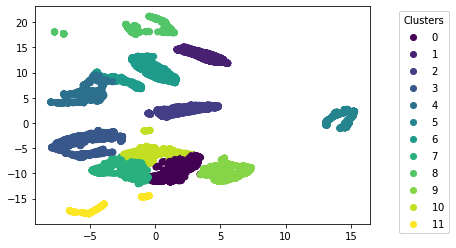

In [15]:
# hyperparameter options
n_clusters_list = [6, 12]
algorithm_list = ['full', 'elkan']
tol_list = [1e-1, 1e-3]
    
for n_clusters in n_clusters_list:
    for algorithm in algorithm_list:
        for tol in tol_list:
            with mlflow.start_run():
                mlflow.set_tag('project', 'my_project' )
                logging_message = f"""
Training KMeans for {n_clusters} clusters, {algorithm} algorithm and tol {tol}...
                """
                print(logging_message)
                train(n_clusters, algorithm, tol)
    

Now it could be interesting to recover the results of an execution we want to explore and maybe load the model to do some predictions.

### Model Loading

#### MLFlow Load

First, let's recover all runs that we've just done.

In [16]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.silhouette,metrics.inertia,params.tol,params.algorithm,params.n_clusters,tags.mlflow.source.name,tags.project,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.log-model.history
0,5bf6702eed304dfc953ac9a88f9c89a3,2,FINISHED,s3://dsla/mlruns/2/5bf6702eed304dfc953ac9a88f9...,2020-03-24 12:00:52.035000+00:00,2020-03-24 12:00:59.668000+00:00,0.528960,34998.903675,0.001,elkan,12,/home/centos/anaconda3/lib/python3.7/site-pack...,my_project,LOCAL,preetam,"[{""run_id"": ""5bf6702eed304dfc953ac9a88f9c89a3""..."
1,0f58e656f69849e58bb140a9707b5973,2,FINISHED,s3://dsla/mlruns/2/0f58e656f69849e58bb140a9707...,2020-03-24 12:00:44.105000+00:00,2020-03-24 12:00:51.865000+00:00,0.525796,35756.716200,0.1,elkan,12,/home/centos/anaconda3/lib/python3.7/site-pack...,my_project,LOCAL,preetam,"[{""run_id"": ""0f58e656f69849e58bb140a9707b5973""..."
2,c080e84152194a93a88efeebbb20a5fe,2,FINISHED,s3://dsla/mlruns/2/c080e84152194a93a88efeebbb2...,2020-03-24 12:00:36.204000+00:00,2020-03-24 12:00:43.944000+00:00,0.528059,35048.638721,0.001,full,12,/home/centos/anaconda3/lib/python3.7/site-pack...,my_project,LOCAL,preetam,"[{""run_id"": ""c080e84152194a93a88efeebbb20a5fe""..."
3,15a34eeabbd64dee8b516aaf3a5b92f7,2,FINISHED,s3://dsla/mlruns/2/15a34eeabbd64dee8b516aaf3a5...,2020-03-24 12:00:28.076000+00:00,2020-03-24 12:00:36.018000+00:00,0.523490,36675.546518,0.1,full,12,/home/centos/anaconda3/lib/python3.7/site-pack...,my_project,LOCAL,preetam,"[{""run_id"": ""15a34eeabbd64dee8b516aaf3a5b92f7""..."
4,4b7edf16cb2f4b94b0d1db73a557c92a,2,FINISHED,s3://dsla/mlruns/2/4b7edf16cb2f4b94b0d1db73a55...,2020-03-24 12:00:20.424000+00:00,2020-03-24 12:00:27.893000+00:00,0.474887,118934.762610,0.001,elkan,6,/home/centos/anaconda3/lib/python3.7/site-pack...,my_project,LOCAL,preetam,"[{""run_id"": ""4b7edf16cb2f4b94b0d1db73a557c92a""..."
5,f30899c1624b45b3aa4de827c2081375,2,FINISHED,s3://dsla/mlruns/2/f30899c1624b45b3aa4de827c20...,2020-03-24 12:00:13.020000+00:00,2020-03-24 12:00:20.264000+00:00,0.470946,119844.497869,0.1,elkan,6,/home/centos/anaconda3/lib/python3.7/site-pack...,my_project,LOCAL,preetam,"[{""run_id"": ""f30899c1624b45b3aa4de827c2081375""..."
6,bb104ce2cf5d45b987db4f7216346654,2,FINISHED,s3://dsla/mlruns/2/bb104ce2cf5d45b987db4f72163...,2020-03-24 12:00:05.263000+00:00,2020-03-24 12:00:12.778000+00:00,0.474467,118936.675861,0.001,full,6,/home/centos/anaconda3/lib/python3.7/site-pack...,my_project,LOCAL,preetam,"[{""run_id"": ""bb104ce2cf5d45b987db4f7216346654""..."
7,25e478acab9043e88b81eee4cc3c2845,2,FINISHED,s3://dsla/mlruns/2/25e478acab9043e88b81eee4cc3...,2020-03-24 11:59:57.052000+00:00,2020-03-24 12:00:05.106000+00:00,0.470946,119844.497869,0.1,full,6,/home/centos/anaconda3/lib/python3.7/site-pack...,my_project,LOCAL,preetam,"[{""run_id"": ""25e478acab9043e88b81eee4cc3c2845""..."
8,3d5ba998686a45adb7d85665845ba652,2,FINISHED,s3://dsla/mlruns/2/3d5ba998686a45adb7d85665845...,2020-03-24 11:59:46.312000+00:00,2020-03-24 11:59:55.290000+00:00,0.528960,34998.903675,0.001,elkan,12,/home/centos/anaconda3/lib/python3.7/site-pack...,None,LOCAL,preetam,"[{""run_id"": ""3d5ba998686a45adb7d85665845ba652""..."
9,24861e9ea9cf47c89b1d415f0dac435b,2,FINISHED,s3://dsla/mlruns/2/24861e9ea9cf47c89b1d415f0da...,2020-03-24 11:59:38.186000+00:00,2020-03-24 11:59:45.536000+00:00,0.528960,34998.903675,0.001,elkan,12,/home/centos/anaconda3/lib/python3.7/site-pack...,None,LOCAL,preetam,"[{""run_id"": ""24861e9ea9cf47c89b1d415f0dac435b""..."


In [17]:
from mlflow.tracking.client import MlflowClient

from datetime import datetime, timedelta
import math
import random

experiment_id =2
runs = mlflow.search_runs(experiment_ids=experiment_id)

earliest_start_time = (datetime.now() - timedelta(days=14)).strftime('%Y-%m-%d')
recent_runs = runs[runs.start_time >= earliest_start_time]

pd.options.mode.chained_assignment = None  # Suppress pandas warning

recent_runs['Run Date'] = recent_runs.start_time.dt.floor(freq='D')

#best_runs_per_day_silhouette_idx = recent_runs.groupby(['Run Date'])['metrics.silhouette'].idxmin()
#best_silhouette_runs = recent_runs.loc[best_runs_per_day_silhouette_idx]

best_runs_idx = recent_runs.groupby(['Run Date'])['metrics.silhouette'].idxmin()
best_runs = recent_runs.loc[best_runs_idx]

display(best_runs[['run_id','Run Date', 'metrics.inertia','metrics.silhouette']])

#import matplotlib.pyplot as plt
#from matplotlib import interactive
#interactive(True)

#plt.plot(best_silhouette_runs[['Run Date']],best_silhouette_runs[['metrics.silhouette']])
#plt.show()

#plt.plot(best_inertia_runs[['Run Date']],best_inertia_runs[['metrics.inertia']])
#plt.show()

,run_id,Run Date,metrics.inertia,metrics.silhouette
5,f30899c1624b45b3aa4de827c2081375,2020-03-24 00:00:00+00:00,119844.497869,0.470946


In [ ]:
%%sh
#export AWS_CA_BUNDLE=/etc/pki/ca-trust/extracted/pem/tls-ca-bundle.pem
export APP_NAME=mlflow-xgb-demo
export MODEL_PATH=s3://dsla/mlruns/2/7c6180f1733b4ae6bfd77648bbd07b2d/artifacts/model
export LOCAL_PORT=8999

mlflow sagemaker run-local -m $MODEL_PATH -p $LOCAL_PORT


Let's then load the last model we've run.

In [18]:
last_run = mlflow.search_runs(max_results=1).loc[0]

model = mlflow.sklearn.load_model(f'runs:/{last_run["run_id"]}/model')
print(model)
                                  
print(f'Inertia: {model.inertia_}')

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=-1, precompute_distances=True,
       random_state=42, tol=0.001, verbose=0)
Inertia: 34998.90367505566


We've loaded the trained model in just one line, specifying the run id to MLFLow.

#### Pickle Load

As expected, we can also load the model in the old way (load from pickle) from the folder where we specified to MLFlow to log the model.

In [19]:
path = f'{last_run["artifact_uri"]}/model'.replace('file:', '')

# ls -al  $path

!aws s3 ls $path  --recursive --human-readable --summarize

2020-03-24 12:01:00  343 Bytes mlruns/2/5bf6702eed304dfc953ac9a88f9c89a3/artifacts/model/MLmodel
2020-03-24 12:00:59  130 Bytes mlruns/2/5bf6702eed304dfc953ac9a88f9c89a3/artifacts/model/conda.yaml
2020-03-24 12:00:59   39.8 KiB mlruns/2/5bf6702eed304dfc953ac9a88f9c89a3/artifacts/model/model.pkl

Total Objects: 3
   Total Size: 40.3 KiB


In [33]:
import pickle
import boto3

s3 = boto3.resource('s3')

path_new="mlruns/2/5bf6702eed304dfc953ac9a88f9c89a3/artifacts/model"
key = f'{path_new}/model.pkl'

model_pkl = pickle.loads(s3.Bucket("dsla").Object(key).get()['Body'].read())

#with open('model.pkl', 'rb') as data:
#    old_list = pickle.load(data)


#with open(f'{path}/model.pkl', 'rb') as data:
#    model_pkl = pickle.load(data)
    
print(model_pkl)                   
print(f'Inertia: {model.inertia_}')

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=-1, precompute_distances=True,
       random_state=42, tol=0.001, verbose=0)
Inertia: 34998.90367505566


### Predictions

All training would not have sense without the ability of making predictions on new data. The following cell checks that the model behaves as expected with some test data.

In [34]:
test_data = df.head()

# if the last MLFlow run is selected the model should have the same 
# parameters as the first example so the clustering variable should
# contain the actual results of the model
actual_data = clustering[:5]

predictions = model.predict(test_data)
print(f'Predictions: {predictions}')

performance = predictions == actual_data
print(f'Performance: {performance}')

Predictions: [3 6 3 5 7]
Performance: [ True  True  True  True  True]


### Prototype to Production

All Data Scientists dream about having their model one day in production. This is freaking simple with MLFlow. It sets up an HTTP endpoint where you can send the data you want to predict and then it can send you back a response from your model.

However you should run on your server the following line in order to setup the endpoint:

```
mlflow models serve -m path_to_your_model -h host -p port
```

It is also necessary to convert the data into a suitable HTTP post body.

In [35]:
http_data = test_data.to_json(orient='split')

http_data

'{"columns":["x","y"],"index":[0,1,2,3,4],"data":[[-2.5409822464,-2.7264602184],[-1.6080690622,12.4178647995],[-3.363984108,-5.8635773659],[14.502576828,2.6358966827],[-2.0515813828,-10.5730810165]]}'

#### requests approach

```python
import requests

host = 'https://usaeilidssbxd01.syngentaaws.org'
port = '8990'

url = f'http://{host}:{port}/invocations'
    
headers = {
    'Content-Type': 'application/json',
}

r = requests.post(url=url, headers=headers, data=http_data)

predictions = [int(x) for x in r.text if x.isdigit()]
print(f'Predictions: {predictions}')

performance = predictions == actual_data
print(f'Performance: {performance}')
```

#### cURL approach

```
curl http://host:port/invocations -H 'Content-Type: application/json' -d http_data
```